In [1]:
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql.functions import col, udf
from pyspark.sql.types import *
from pyspark import SparkContext
from matplotlib import pyplot 

sample = True

sc = SparkSession.builder.getOrCreate()
sqlContext = SQLContext(sc)

class GoogleNormalizer:
    categories_map = {
        'Game': ['Action', 'Adventure', 'Arcade', 'Board', 'Card', 'Casino', 'Casual', 'Educational', 'Music', 'Puzzle', 'Racing', 'Role Playing', 'Simulation', 'Sports', 'Strategy', 'Trivia', 'Word'],
        'Music': ['Music & Audio'],
        'Health': ['Health & Fitness']
    }
    categories_inverted_map = dict((i, key) for key, values in categories_map.items() for i in values)
    
    @staticmethod
    def convert_size_to_bytes(raw_size):
        multipliers = {
            'k': 1024,
            'm': 1024*1024,
            'g': 1024*1024*1024,
        }
        if raw_size:
            size = raw_size.replace(',', '')
            for suffix in multipliers:
                if size.lower().endswith(suffix):
                    return int(float(size[0:-len(suffix)]) * multipliers[suffix])
            else:
                if size.lower().endswith('b'):
                    return int(size[0:-1])
                else:
                    try:
                        return int(size)
                    except ValueError: # for example "1024x"
                        return None
        else:
            return None

    @staticmethod 
    def normalize_size(size):
        result = GoogleNormalizer.convert_size_to_bytes(size)
        if result == 0:
            return None
        else:
            return result

    @staticmethod
    def normalize_google_category(cat):
        return GoogleNormalizer.categories_inverted_map.get(cat)
    
    @staticmethod
    def normalize(raw_google_df):
        normalize_size_udf = udf(lambda z: GoogleNormalizer.normalize_size(z))
        normalize_google_category_udf = udf(lambda z: GoogleNormalizer.normalize_google_category(z))
        google_df = raw_google_df \
            .withColumn('normalized_size', normalize_size_udf(col('Size')).cast(IntegerType())) \
            .withColumn('normalized_category', normalize_google_category_udf(col('Category'))) \
            .withColumn('avg_rating', col('Rating').cast(FloatType())) \
            .withColumn('rating_count', col('Rating Count').cast(IntegerType())) \
            .withColumn('Released', col('Released').cast(DateType())) \
            .withColumn('App_Name', col('App Name').cast(DateType())) \
            .withColumn('App_Id', col('App Id').cast(DateType()))
        return google_df
    
class AppleNormalizer:
    categories_map = {
        'Game': ['Games'],
        'Music': ['Music'],
        'Health': ['Health & Fitness'],
    }
    categories_inverted_map = dict((i, key) for key, values in categories_map.items() for i in values)

    @staticmethod
    def normalize_apple_category(cat):
        return AppleNormalizer.categories_inverted_map.get(cat)

    @staticmethod
    def normalize(raw_apple_df):
        normalize_size_udf = udf(lambda z: GoogleNormalizer.normalize_size(z))
        normalize_apple_category_udf = udf(lambda z: AppleNormalizer.normalize_apple_category(z))
        apple_df = raw_apple_df \
            .withColumn('normalized_size', normalize_size_udf(col('Size_Bytes')).cast(IntegerType())) \
            .withColumn('normalized_category', normalize_apple_category_udf(col('Primary_Genre'))) \
            .withColumn('avg_rating', col('Average_User_Rating').cast(FloatType())) \
            .withColumn('rating_count', col('Reviews').cast(IntegerType())) \
            .withColumn('Released', col('Released').cast(DateType()))
        return apple_df

raw_apple_df = sqlContext.read.format('csv').load("/data/appleAppData%s.csv" % ('.sample' if sample else ''), header='true', infer_schema='true')
AppleNormalizer.normalize(raw_apple_df).createOrReplaceTempView("apple_apps")

raw_google_df = sqlContext.read.format('csv').load("/data/Google-Playstore%s.csv" % ('.sample' if sample else ''), header='true', infer_schema='true')
GoogleNormalizer.normalize(raw_google_df).createOrReplaceTempView("google_apps")

categories = ['Game', 'Music', 'Health']


/usr/local/spark/python/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


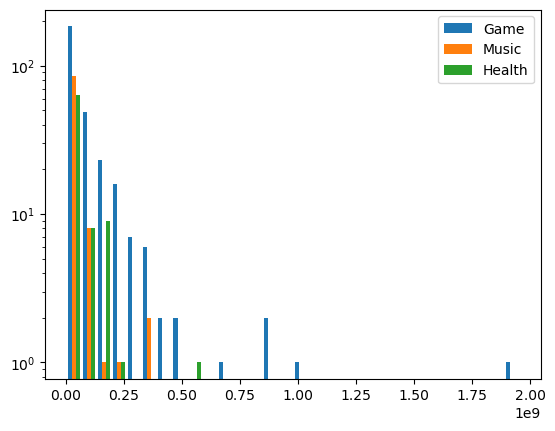

In [2]:
# Draw histo for size by category

size_and_categories_df = sqlContext.sql("select normalized_size as size, normalized_category as category from google_apps") \
  .union(sqlContext.sql("select normalized_size as size, normalized_category as category from apple_apps"))

size_and_categories_df.createOrReplaceTempView("size_and_categories")

size_and_cat_histo = sqlContext.sql("select size, category from size_and_categories where category is not null and size is not null")

pyplot.hist([
    [r['size'] for r in size_and_cat_histo.filter(col('category') == cat).select('size').collect()] for cat in categories
], 30, label=categories, log=True)
pyplot.legend()

# end: Draw histo

In [3]:
# Rating average

reviews_df = sqlContext.sql("select avg_rating, rating_count, normalized_category as category from google_apps") \
  .union(sqlContext.sql("select avg_rating, rating_count, normalized_category as category from apple_apps"))
reviews_df.createOrReplaceTempView('reviews')

sqlContext.sql("select category, sum(avg_rating * rating_count)/sum(rating_count) from reviews group by category").show()

# end: Rating average

+--------+------------------------------------------------------+
|category|(sum((avg_rating * rating_count)) / sum(rating_count))|
+--------+------------------------------------------------------+
|    null|                                      4.41074540767641|
|  Health|                                    3.8815187752025277|
|   Music|                                    4.7130506274216515|
|    Game|                                     4.324328792824674|
+--------+------------------------------------------------------+



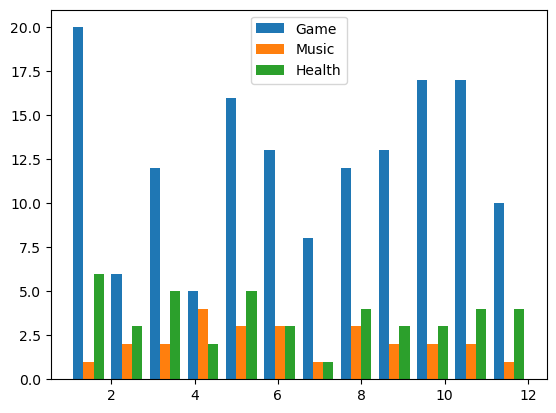

In [4]:
# New releases by month

released_df = sqlContext.sql("select normalized_category as category, Released from google_apps") \
  .union(sqlContext.sql("select normalized_category as category, Released from apple_apps"))
released_df.createOrReplaceTempView('released')

released_by_category_df = sqlContext.sql("select category, MONTH(Released) as month from released where category is not null and Released is not null")

pyplot.hist([
    [r['month'] for r in released_by_category_df.filter(col('category') == cat).select('month').collect()] for cat in categories
], 12, label=categories)
pyplot.legend()

# end: New releases by month

In [5]:
# Top ten by size by category and year

released_by_size_df = sqlContext.sql("select App_Name, normalized_category as category, normalized_size as size, YEAR(Released) as year from google_apps") \
  .union(sqlContext.sql("select App_Name, normalized_category as category, normalized_size as size, YEAR(Released) as year from apple_apps"))
released_by_size_df.createOrReplaceTempView('released_by_size')

sqlContext.sql("""SELECT category, year, size, App_Name FROM 
   (SELECT App_Name, category, year as year, size, dense_rank() 
         OVER (PARTITION BY category, year ORDER BY size DESC) as rank 
    FROM released_by_size where category is not null and year is not null) tmp  
WHERE rank <= 10 order by 1, 2""").show(100)

# end: # Top ten by size by category and year

+--------+----+----------+---------------------------------+
|category|year|      size|                         App_Name|
+--------+----+----------+---------------------------------+
|    Game|2010|1956236288|                  Smurfs' Village|
|    Game|2010|  10951680|                             Trex|
|    Game|2012| 149217280|             Trucks JigSaw Puz...|
|    Game|2012|  71523328|             Chicken Invaders ...|
|    Game|2012|  54022144|                     Tap To Death|
|    Game|2013|  58639360|                        Hard Time|
|    Game|2013|  49485824|             Tank Island 3D - ...|
|    Game|2013|  14888960|             Guess word from 4...|
|    Game|2014| 508649472|             Frontline: Road t...|
|    Game|2014| 184221696|             Elephant Simulato...|
|    Game|2014| 117760000|                          FoxRunn|
|    Game|2014|  90632192|             American fire tru...|
|    Game|2014|  89284608|             New York Mad Taxi...|
|    Game|2014|  4493824